In [1]:
# General imports
import os
import sys
import math
import json
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Sinergym
import sinergym
from src.wrappers import SinergymWrapper
from src.rewards import FangerReward

# Model
import ray
import torch.nn as nn
from ray.rllib.algorithms.ppo import PPO


# Flag: weahter to use Active RL or not
DESC = 'PPO_activation_gamma99_'

In [2]:
# Remove old environments
!find . -type d -name 'Eplus-env-*' -exec rm -rf {} +

In [3]:
# Add the EnergyPlus path to the system path
sys.path.append('./EnergyPlus-23-1-0')
# Set the EnergyPlus path as an environment variable
os.environ['EPLUS_PATH'] = './EnergyPlus-23-1-0'
# Ignore deprecation warnings
os.environ['PYTHONWARNINGS'] = 'ignore::DeprecationWarning'

In [4]:
# Environment ID
env_id = "Eplus-5zone-hot-continuous-stochastic-v1"

# Weather
weather_files = ['USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw']

# mu, sigma and theta for the weather variability
# In the original version, weather_variability was a triple (mu, sigma, theta)
# that only affected the drybulb (outdoor temperature), while now it is a dictionary
# with the mean, sigma and theta for each weather variable we want to vary.
# NOTE: Check apply_weather_variability method in CustomModelJSON class
weather_variability = {
    'drybulb': np.array([5.53173187e+00, 0.00000000e+00, 2.55034944e-03]), 
    'relhum': np.array([1.73128872e+01, 0.00000000e+00, 2.31712760e-03]), 
    'winddir': np.array([7.39984654e+01, 0.00000000e+00, 4.02298013e-04]), 
    'dirnorrad': np.array([3.39506556e+02, 0.00000000e+00, 9.78192172e-04]), 
    'windspd': np.array([1.64655725e+00, 0.00000000e+00, 3.45045547e-04])
}

# Initialize with a single factor
initial_factors = ['drybulb']
# Define all factors you eventually want to include
all_factors = ['drybulb', 'relhum', 'winddir', 'dirnorrad', 'windspd']

# Custom reward derived from Fanger's comfort model.
# This extends the LinearReward class from sinergym adding ppd and occupancy variables.
reward = FangerReward
reward_kwargs={
    'temperature_variables': ['air_temperature'],
    'energy_variables': ['HVAC_electricity_demand_rate'],
    'range_comfort_winter': [20, 23],
    'range_comfort_summer': [23, 26],
    'energy_weight': 0.1,
    'ppd_variable': 'Zone Thermal Comfort Fanger Model PPD(SPACE1-1 PEOPLE 1)',
    'occupancy_variable': 'Zone People Occupant Count(SPACE1-1)'
}

# Environment configuration
env_config = {
    'env_id': env_id,
    'weather_files': weather_files,
    'reward': reward,
    'reward_kwargs': reward_kwargs,
    'weather_variability': weather_variability, #{'drybulb': weather_variability['drybulb']},
}

I adopted the strategy of Curriculum Learning. That said, the training will start with a simpler version of the environment, where only the external temperature varies. Through epochs, more external factors are added, making the environment more complex. This is done by modifying the weather_variability in a dynamic way.

In [5]:
# Initialize ray
ray.init(ignore_reinit_error=True)

# Get the default configuration
config = PPO.get_default_config()

# Environment specific configuration
config['env'] = SinergymWrapper
config['env_config'] = env_config

# Hardware specific configuration
config['num_gpus'] = 1
config['use_gpu'] = True

# Model configuration
# config['model']['use_attention'] = True
config['model']['fcnet_activation'] = lambda: nn.Sequential(nn.Tanh(), nn.Dropout(p=0.3))

# Training configuration
# config['train_batch_size'] = 4000
# config['entropu_coeff'] = 0.02                  # Regularization term to encourage exploration                  
# config['rollout_fragment_length'] = "auto"
# config['sgd_minibatch_size'] = 256
# config['clip_param'] = 0.2
# config['gamma'] = 0.80                            # Best discount factor for the task is 0.8
#config['lr'] = 1e-4

# Initialize the trainer
trainer = PPO(config=config)

2024-03-14 21:34:44,406	INFO worker.py:1724 -- Started a local Ray instance.
/home/luigi/Documents/SmartEnergyOptimizationRL/.venv/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/luigi/Documents/SmartEnergyOptimizationRL/.venv/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/luigi/D

(RolloutWorker pid=15344) #==============================================================================================#
(RolloutWorker pid=15344) [ENVIRONMENT] (INFO) : Creating Gymnasium environment... [5zone-hot-continuous-stochastic-v1]
(RolloutWorker pid=15344) #==============================================================================================#
(RolloutWorker pid=15343) [MODELING] (INFO) : Experiment working directory created [/home/luigi/Documents/SmartEnergyOptimizationRL/Eplus-env-5zone-hot-continuous-stochastic-v1-res2]
(RolloutWorker pid=15343) [MODELING] (INFO) : Model Config is correct.
(RolloutWorker pid=15343) [MODELING] (INFO) : Updated building model with whole Output:Variable available names
(RolloutWorker pid=15343) [MODELING] (INFO) : Updated building model with whole Output:Meter available names
(RolloutWorker pid=15343) [MODELING] (INFO) : runperiod established: {'start_day': 1, 'start_month': 1, 'start_year': 1991, 'end_day': 31, 'end_month': 12, 'en

(RolloutWorker pid=15344) /home/luigi/Documents/SmartEnergyOptimizationRL/.venv/lib/python3.10/site-packages/gymnasium/wrappers/compatibility.py:60: DeprecationWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v1.0. Instead use `gymnasium.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`
(RolloutWorker pid=15344)   logger.deprecation(
(RolloutWorker pid=15343) 2024-03-14 21:34:49,289	WARNING utils.py:160 -- `config.auto_wrap_old_gym_envs` is activated AND you seem to have provided an old gym-API environment. RLlib will therefore try to auto-fix the following error. However, please consider switching over to the new `gymnasium` APIs:
(RolloutWorker pid=15343) Your environment ({}) does not abide to the new gymnasium-style API!
(RolloutWorker pid=15343) From Ray 2.3 on, RLlib only supports the new (gym>=0.26 or gymnasium) Env APIs.
(RolloutWorker pid=15343) {}
(RolloutWorker pid=153

(RolloutWorker pid=15344) [ENVIRONMENT] (INFO) : Saving episode output path... [/home/luigi/Documents/SmartEnergyOptimizationRL/Eplus-env-Eplus-5zone-hot-continuous-stochastic-v1-res1/Eplus-env-sub_run1/output]
(RolloutWorker pid=15343) [SIMULATOR] (INFO) : Running EnergyPlus with args: ['-w', '/home/luigi/Documents/SmartEnergyOptimizationRL/Eplus-env-Eplus-5zone-hot-continuous-stochastic-v1-res2/Eplus-env-sub_run1/USA_AZ_Davis-Monthan.AFB.722745_TMY3_Random_1.64655725_0.0_0.000345045547.epw', '-d', '/home/luigi/Documents/SmartEnergyOptimizationRL/Eplus-env-Eplus-5zone-hot-continuous-stochastic-v1-res2/Eplus-env-sub_run1/output', '/home/luigi/Documents/SmartEnergyOptimizationRL/Eplus-env-Eplus-5zone-hot-continuous-stochastic-v1-res2/Eplus-env-sub_run1/5ZoneAutoDXVAV.epJSON']
(RolloutWorker pid=15343) [ENVIRONMENT] (INFO) : Episode 1 started.
(RolloutWorker pid=15343) [SIMULATOR] (INFO) : handlers initialized.
(RolloutWorker pid=15343) [SIMULATOR] (INFO) : handlers are ready.
(RolloutWo

2024-03-14 21:34:58,887	INFO trainable.py:164 -- Trainable.setup took 13.785 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-03-14 21:34:58,888	WARNING util.py:62 -- Install gputil for GPU system monitoring.


In [6]:
# Define a function to update weather_variability based on the current step
def update_weather_variability(step, initial_variability, factors, steps_per_increase):
    # Calculate the number of factors to include based on the current step
    num_factors = min(len(factors), (step // steps_per_increase) + 1)
    # Update weather_variability to only include the first 'num_factors' factors
    new_variability = {factor: initial_variability[factor] for factor in factors[:num_factors]}
    return new_variability

def save_latest_environment_config(config, file_path='data/latest_env_config.json'):
    # Convert NumPy arrays to lists for JSON serialization
    config_serializable = {}
    for key, value in config.items():
        if isinstance(value, np.ndarray):
            config_serializable[key] = value.tolist()
        else:
            config_serializable[key] = value
    
    with open(file_path, 'w') as f:
        json.dump(config_serializable, f)


In [7]:
# Initialize the rewards list and number of episodes
rewards = []
num_episodes = int(5e2)

# Increase complexity every steps_per_increase episodes
# 75% of the episodes will be used to increase the complexity
steps_per_increase = int(num_episodes * 0.8 / len(weather_variability))         

# Define the save paths
save_path = f'checkpoints/{DESC}{num_episodes}_episodes'
rewards_save_path = f'results/{DESC}rewards_{num_episodes}_episodes.npy'

# Iterate over num_episodes episodes
for i in tqdm(range(num_episodes), desc="Training"):
    # Update the environment complexity based on the current episode
    if i % steps_per_increase == 0 or i == 0:
        # Update the environment configuration (save the latest configuration to a file)
        new_config = update_weather_variability(i, weather_variability, all_factors, steps_per_increase)
        save_latest_environment_config(new_config)
        
    # Train the model
    result = trainer.train()

    # Check if the reward is not nan
    if not math.isnan(result['episode_reward_mean']):
        # Append the reward to the rewards list
        rewards.append(result['episode_reward_mean'])
    
    # Save the model every 10 episodes
    if i % 10 == 0:
        trainer.save(save_path)

# Save the array to a file
np.save(rewards_save_path, np.array(rewards))

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Progress: |**-------------------------------------------------------------------------------------------------| 2%
Progress: |***------------------------------------------------------------------------------------------------| 3%
Progress: |*****----------------------------------------------------------------------------------------------| 5%
Progress: |*****----------------------------------------------------------------------------------------------| 5%
Progress: |********-------------------------------------------------------------------------------------------| 8%
Progress: |********-------------------------------------------------------------------------------------------| 8%
Progress: |********-------------------------------------------------------------------------------------------| 8%
Progress: |************---------------------------------------------------------------------------------------| 12%
Progress: |***********---------------------------------------------------------

2024-03-14 21:35:05,964	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


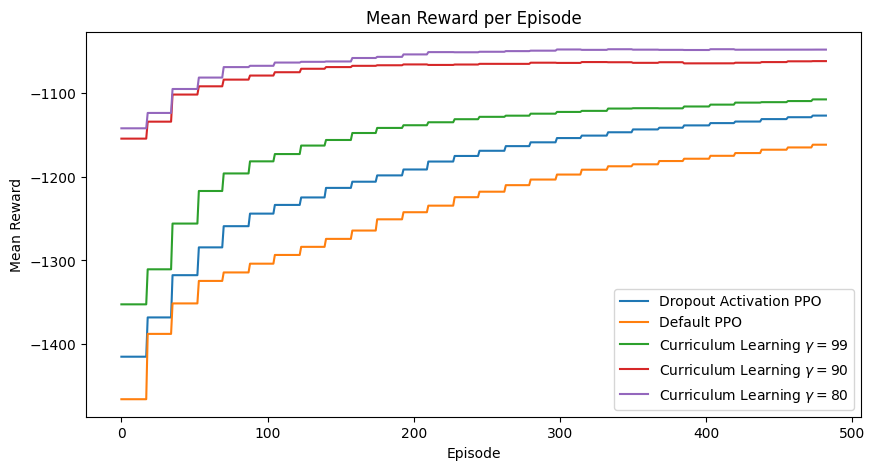

In [29]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot the rewards
plt.plot(np.load('results/PPO_allDefault_rewards_500_episodes.npy'), label='Default PPO')
plt.plot(np.load('results/PPO_activation_gamma99_rewards_500_episodes.npy'), label='Dropout Activation PPO')
plt.plot(np.load('results/Curr_Learning_gamma99_rewards_500_episodes.npy'), label='Curriculum Learning $\gamma=99$')
plt.plot(np.load('results/Curr_Learning_gamma90_rewards_500_episodes.npy'), label='Curriculum Learning $\gamma=90$')
plt.plot(np.load('results/Curr_Learning_gamma80_rewards_500_episodes.npy'), label='Curriculum Learning $\gamma=80$')

plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode')
plt.legend()
plt.savefig('results/plot5.png')
plt.show()